<a href="https://colab.research.google.com/github/kishore145/AI-ML-Foundations/blob/master/Neural%20Networks/19_ResNet_using_tensorlfow_on_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture  

ResNet uses very deep layers using residual blocks.   
You can read more about it in the original paper : https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf  

| output map size | 32 x 32 | 16 x 16 | 8 x 8 |  
| :---: | :---: | :----: | :----:|  
| # layers | 1+2n | 2n | 2n | 
| # filters | 16 | 32 | 64 |

ex:  n = 3

| output map size | 32 x 32 | 16 x 16 | 8 x 8 |  
| :---: | :---: | :----: | :----:|  
| # layers | 1+7 | 6 | 6 | 
| # filters | 16 | 32 | 64 |




# Load dependencies and pre-process data

In [42]:
# Load dependencies
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, AveragePooling2D, Input
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import os

import numpy as np

In [43]:
(X_train_cifar, y_train_cifar), (X_valid_cifar, y_valid_cifar) = cifar10.load_data()

In [44]:
# Check the shape of the data to ensure data is downloaded correctly
def datashape(X_train, y_train, X_valid, y_valid):
  print(f'''X_train shape: {X_train.shape},
  y_train shape: {y_train.shape},
  X_valid shape: {X_valid.shape},
  y_valid shape: {y_valid.shape}\n''')


In [45]:
# Review the revised shape of feature vector and target labels
print('Shape of cifar data set:')
datashape(X_train_cifar, y_train_cifar, X_valid_cifar, y_valid_cifar)

Shape of cifar data set:
X_train shape: (50000, 32, 32, 3),
  y_train shape: (50000, 1),
  X_valid shape: (10000, 32, 32, 3),
  y_valid shape: (10000, 1)



In [46]:
# Reshape the numpy array to float32
# Preprocess data - Input to conv is a 4D tensor with shape (batch_size, rows, cols, channels) as default which can be changed by data_format, 
def preprocess(X_train, y_train, X_valid, y_valid, X_trainshape, X_validshape, n_classes, subtract_pixel_mean):
  # Reshape X_train and X_valid
  X_train = X_train.reshape(X_trainshape).astype('float32')
  X_valid = X_valid.reshape(X_validshape).astype('float32')
  # Min max scaling
  X_train /= 255.
  X_valid /= 255.
  # Subtract mean value for better accuracy
  if subtract_pixel_mean:
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_valid -= X_train_mean
  y_train = to_categorical(y_train, n_classes)
  y_valid = to_categorical(y_valid, n_classes)

  return X_train, y_train, X_valid, y_valid


In [47]:
n_classes = 10

In [48]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
# Preprocess train and validation data sets.
X_train_cifar, y_train_cifar, X_valid_cifar, y_valid_cifar = preprocess(X_train_cifar, y_train_cifar, 
                                                                        X_valid_cifar, y_valid_cifar,
                                                                        (50000, 32, 32, 3), (10000, 32,32,3),
                                                                        n_classes, subtract_pixel_mean)

# Review the revised shape of feature vector and target labels
print('Shape of cifar data set:')
datashape(X_train_cifar, y_train_cifar, X_valid_cifar, y_valid_cifar)

Shape of cifar data set:
X_train shape: (50000, 32, 32, 3),
  y_train shape: (50000, 10),
  X_valid shape: (10000, 32, 32, 3),
  y_valid shape: (10000, 10)



# Design Resnet Architecture

In [26]:
# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

# The Number of parameters is approx :
#   ResNet20 0.27M
#   ResNet32 0.46M
#   ResNet44 0.66M
#   ResNet56 0.85M
#   ResNet110 1.7M

In [27]:
# Set hyper parameters
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 20 # higher epochs like 200 times out in colab
# data_augmentation = True # Original paper had data augmentation
num_classes = 10



In [28]:
# Reduce learning rate after specific epochs


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    if(epoch in [81,121,161,181]):
      print('Learning rate: ', lr)
    return lr


In [29]:
# Function for creating resnet layers.

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True):
    """2D Convolution->Batch Normalization->Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        
    # Returns
        a (tensor): tensor as input to the next layer
    """
    # Create a conv2D layer with supplied parameters
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    z = conv(inputs) # run the input through conv layer
    if batch_normalization: # Apply batch normalization
        z = BatchNormalization()(z)
    if activation is not None: # Apply activation function
        a = Activation(activation)(z)
        return a
    else:
        return z

In [30]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same feature map size.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx :
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    layer_counter = 0
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape) # Create i/p layer with desired shape 
    al = resnet_layer(inputs=inputs) # Create a resnet layer with input
    # Instantiate the stack of residual units
    # Stack size is 3 as mentioned in the architecture section with each stack
    # containing 2n layers
    for stack in range(3): 
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample at begining of each stack
            # First 3x3 conv layer with activation
            al1 = resnet_layer(inputs=al,
                             num_filters=num_filters,
                             strides=strides)
            # Second 3x3 conv layer without activation
            zl2 = resnet_layer(inputs=al1,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                al = resnet_layer(inputs=al,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            zl2 = keras.layers.add([al, zl2])
            al2 = Activation('relu')(zl2)
            # updating activation layer for next resblock
            al = al2
            layer_counter += 2
        num_filters *= 2
        
    #print(f'Resnet Layer count : {layer_counter}')
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(al2)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [31]:
# Create model for different depths for cifar data set
from keras.utils.layer_utils import count_params

input_shape = X_train_cifar.shape[1:]
cifar_models = {}
# Resnet 110 takes too long to train. 
for n in [3, 5, 7, 9]:
  depth = n*6 + 2
  cifar_models[f'ResNet{depth}'] = resnet_v1(input_shape=input_shape, depth=depth)
  cifar_models[f'ResNet{depth}'].compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
  trainable_count = count_params(cifar_models[f'ResNet{depth}'].trainable_weights)
  non_trainable_count = count_params(cifar_models[f'ResNet{depth}'].non_trainable_weights)

  print(f'\nResnet{depth} summary : depth = {depth}, n = {n}')
  print(f'Trainable parameters: {trainable_count}')
  print(f'Non trainable parameters: {non_trainable_count}')
  print(f'Total parameters: {(trainable_count + non_trainable_count)/1e6}M')

print(f'\nTotal Number of models to evaluate: {len(cifar_models)}')


Resnet20 summary : depth = 20, n = 3
Trainable parameters: 273066
Non trainable parameters: 1376
Total parameters: 0.274442M

Resnet32 summary : depth = 32, n = 5
Trainable parameters: 467946
Non trainable parameters: 2272
Total parameters: 0.470218M

Resnet44 summary : depth = 44, n = 7
Trainable parameters: 662826
Non trainable parameters: 3168
Total parameters: 0.665994M

Resnet56 summary : depth = 56, n = 9
Trainable parameters: 857706
Non trainable parameters: 4064
Total parameters: 0.86177M

Total Number of models to evaluate: 4


In [32]:
# Setting call backs
# Set o/p directory
callbacks_cifar = {}
for model_name in cifar_models.keys():
  output_dir_cifar = f'model_output/cifar/{model_name}'
  checkpoint = ModelCheckpoint(filepath=output_dir_cifar + '/weights_best.hdf5', 
                                  monitor = 'val_accuracy', save_best_only = True, verbose = 0)
  # Verifying o/p path exists
  if not os.path.exists(output_dir_cifar):
    os.makedirs(output_dir_cifar)
  
  lr_scheduler = LearningRateScheduler(lr_schedule)
  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6 )
  callbacks_cifar[model_name] = [checkpoint, lr_reducer, lr_scheduler]


In [33]:
hists = {}
for model_name, model in cifar_models.items():
  print(f'{model_name}')
  print('Start training...')
  hists[model_name] = model.fit(X_train_cifar, y_train_cifar,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(X_valid_cifar, y_valid_cifar),
                                shuffle=True, 
                                callbacks=callbacks_cifar[model_name], 
                                verbose = 0)
  print('Training completed...')

ResNet20
Start training...
Training completed...
ResNet32
Start training...
Training completed...
ResNet44
Start training...
Training completed...
ResNet56
Start training...
Training completed...


# Model evaluation

In [36]:
for model_name, model in cifar_models.items():
  output_dir_cifar = f'model_output/cifar/{model_name}'
  model.load_weights(filepath = output_dir_cifar + '/weights_best.hdf5')
  # Score trained model.
  scores = model.evaluate(X_valid_cifar, y_valid_cifar, verbose=0)
  print(f'\nEvaluation metrics for {model_name}')
  print('Validation loss:', scores[0])
  print('Validation accuracy:', scores[1])
  


Evaluation metrics for ResNet20
Validation loss: 1.0474435091018677
Validation accuracy: 0.7825000286102295

Evaluation metrics for ResNet32
Validation loss: 0.8668304681777954
Validation accuracy: 0.8192999958992004

Evaluation metrics for ResNet44
Validation loss: 0.9969196319580078
Validation accuracy: 0.7971000075340271

Evaluation metrics for ResNet56
Validation loss: 0.9073085784912109
Validation accuracy: 0.7953000068664551


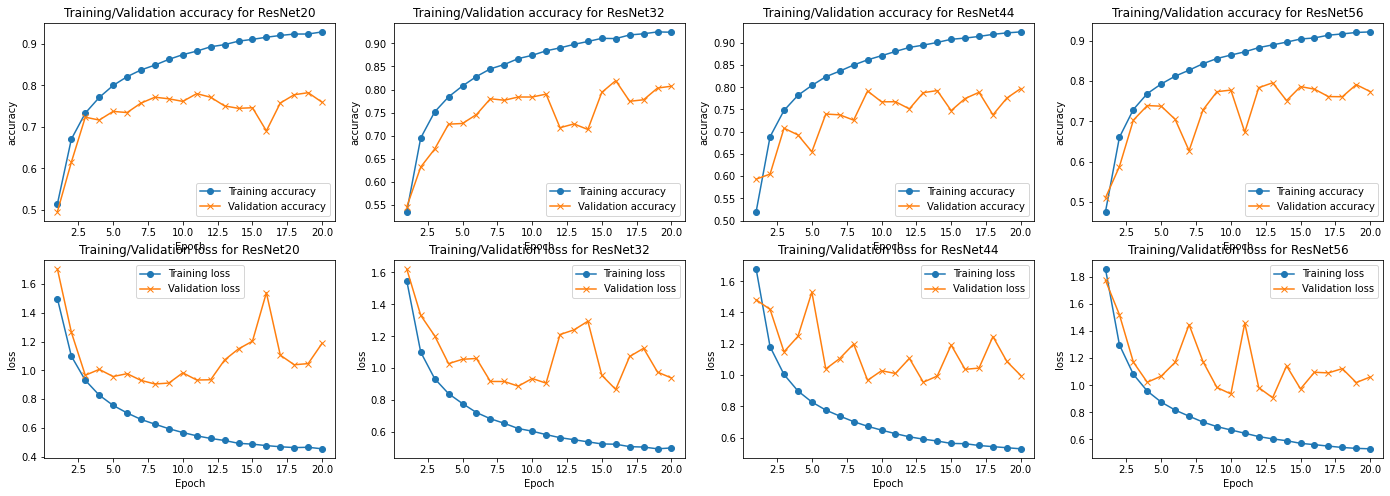

In [41]:
# Plotting variation in acccuracy over epochs
# You can see overfitting happening in the graph
import matplotlib.pyplot as plt

def plot_metrics(ax, hist, metric, model_name):
  ax.plot([None] + hist.history[metric], 'o-')
  ax.plot([None] + hist.history[f'val_{metric}'], 'x-')
  # Plot legend and use the best location automatically: loc = 0.
  ax.legend([f'Training {metric}', f'Validation {metric}'], loc = 0)
  ax.set_title(f'Training/Validation {metric} for {model_name}')
  ax.set_xlabel('Epoch')
  ax.set_ylabel(metric)

fig, axs = plt.subplots(2, 4, figsize = (24, 8))
i = 0
for model_name, hist in hists.items():
  plot_metrics(axs[0,i], hist, 'accuracy', model_name)
  plot_metrics(axs[1,i], hist, 'loss', model_name)
  i += 1





In [ ]:
# Since the number of epochs is too low for such a deep architecture and 
# due to no data augmentation, not a lot of inferencing can occur from the training set
# But on a high level, as you can see on the graphs, the training loss continues to go down
# even at higher depths like resnet 56. 
# Code is based on keras example
# https://keras.io/examples/cifar10_resnet/
